In [1]:
from tensorflow_datasets import load
from tensorflow_datasets import as_numpy

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Dropout, Conv2DTranspose, Reshape, BatchNormalization, UpSampling2D
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.cluster import KMeans, SpectralClustering, FeatureAgglomeration, MeanShift, MiniBatchKMeans

import cv2

import numpy as np
import matplotlib.pyplot as plt

# Готовим данные

In [2]:
(img_train, label_train), (img_test, label_test) = as_numpy(load(
    'HorsesOrHumans',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [6]:
img_train = np.array(list(map(lambda x: cv2.resize(x, (64, 64)), img_train)))
img_test = np.array(list(map(lambda x: cv2.resize(x, (64, 64)), img_test)))
img_train = np.array(list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), img_train)))
img_test = np.array(list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), img_test)))
# img_train = np.array(list(map(lambda x: cv2.Canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), 100, 200), img_train)))
# img_test = np.array(list(map(lambda x: cv2.Canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), 100, 200), img_test)))

In [7]:
print(img_train.shape)
print(label_train.shape)
print(img_test.shape)
print(label_test.shape)

(1027, 64, 64)
(1027,)
(256, 64, 64)
(256,)


In [9]:
img_train = 255 - img_train
img_test = 255 - img_test

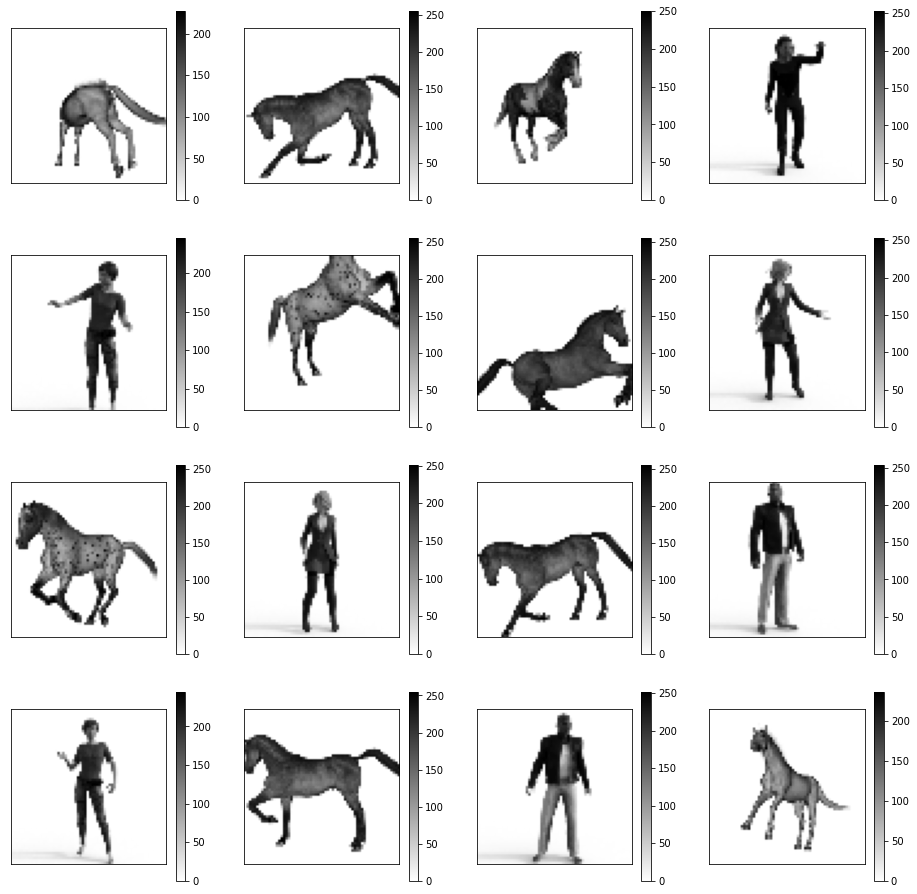

In [10]:
i = 1
plt.figure(figsize=(16, 16))
for img in img_test[:16]:
  plt.subplot(4, 4, i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap='binary')
  plt.colorbar()
  i += 1
plt.show()

In [11]:
img_train_conv = img_train[...,None] / 255
img_test_conv = img_test[...,None] / 255
print(img_train_conv.shape)
print(img_test_conv.shape)
print(img_train_conv.max())
print(img_test_conv.max())
print(img_train_conv.min())
print(img_test_conv.min())

(1027, 64, 64, 1)
(256, 64, 64, 1)
1.0
1.0
0.0
0.0


# Создаем модель

In [12]:
enc_inp = Input((64, 64, 1))
enc_layer = Conv2D(32, 3, strides=2, padding='same', activation='relu')(enc_inp)
enc_layer = Dropout(0.2)(enc_layer)
# enc_layer = MaxPool2D((2, 2))(enc_layer)
enc_layer = Conv2D(64, 3, strides=2, padding='same', activation='relu')(enc_layer)
enc_layer = Dropout(0.2)(enc_layer)
# enc_layer = MaxPool2D((2, 2))(enc_layer)
enc_layer = Conv2D(128, 3, strides=2, padding='same', activation='relu')(enc_layer)
enc_layer = Dropout(0.2)(enc_layer)
# enc_layer = MaxPool2D((2, 2))(enc_layer)
enc_layer = Flatten()(enc_layer)
# enc_layer = Dense(256, activation='relu')(enc_layer)
# enc_layer = Dense(256, activation='relu')(enc_layer)
enc_out = Dense(256, activation='relu')(enc_layer)

encoder = Model(enc_inp, enc_out)

In [13]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0     

In [14]:
dec_inp = Input((256,))
dec_layer = Dense(8192, activation='relu')(dec_inp)
dec_layer = Reshape((8, 8, 128))(dec_layer)
# dec_layer = UpSampling2D((2, 2))(dec_layer)
dec_layer = Dropout(0.2)(dec_layer)
dec_layer = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(dec_layer)
dec_layer = Dropout(0.2)(dec_layer)
# dec_layer = UpSampling2D((2, 2))(dec_layer)
dec_layer = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(dec_layer)
dec_layer = Dropout(0.2)(dec_layer)
# dec_layer = UpSampling2D((2, 2))(dec_layer)
dec_layer = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(dec_layer)
dec_out = Conv2D(1, 3, padding='same', activation='sigmoid')(dec_layer)


decoder = Model(dec_inp, dec_out)

In [15]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        7379

In [16]:
model = Model(enc_inp, decoder(encoder(enc_inp)))

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 256)               2190080   
_________________________________________________________________
model_1 (Functional)         (None, 64, 64, 1)         2345473   
Total params: 4,535,553
Trainable params: 4,535,553
Non-trainable params: 0
_________________________________________________________________


# Обучаем

In [18]:
model.compile(
      optimizer=Adam(),
      loss='mse'
  )
model.fit(img_train_conv, img_train_conv, epochs=150, batch_size=100, validation_data=(img_test_conv, img_test_conv))

Epoch 1/150
11/11 [==============================] - 4s 148ms/step - loss: 0.0750 - val_loss: 0.2073
Epoch 2/150
11/11 [==============================] - 1s 77ms/step - loss: 0.0706 - val_loss: 0.1793
Epoch 3/150
11/11 [==============================] - 1s 84ms/step - loss: 0.0499 - val_loss: 0.1039
Epoch 4/150
11/11 [==============================] - 1s 78ms/step - loss: 0.0354 - val_loss: 0.0736
Epoch 5/150
11/11 [==============================] - 1s 83ms/step - loss: 0.0317 - val_loss: 0.0761
Epoch 6/150
11/11 [==============================] - 1s 78ms/step - loss: 0.0283 - val_loss: 0.0746
Epoch 7/150
11/11 [==============================] - 1s 78ms/step - loss: 0.0262 - val_loss: 0.0695
Epoch 8/150
11/11 [==============================] - 1s 78ms/step - loss: 0.0248 - val_loss: 0.0660
Epoch 9/150
11/11 [==============================] - 1s 78ms/step - loss: 0.0233 - val_loss: 0.0612
Epoch 10/150
11/11 [==============================] - 1s 77ms/step - loss: 0.0222 - val_loss: 0.051

In [19]:
predict = model.predict(img_test_conv)

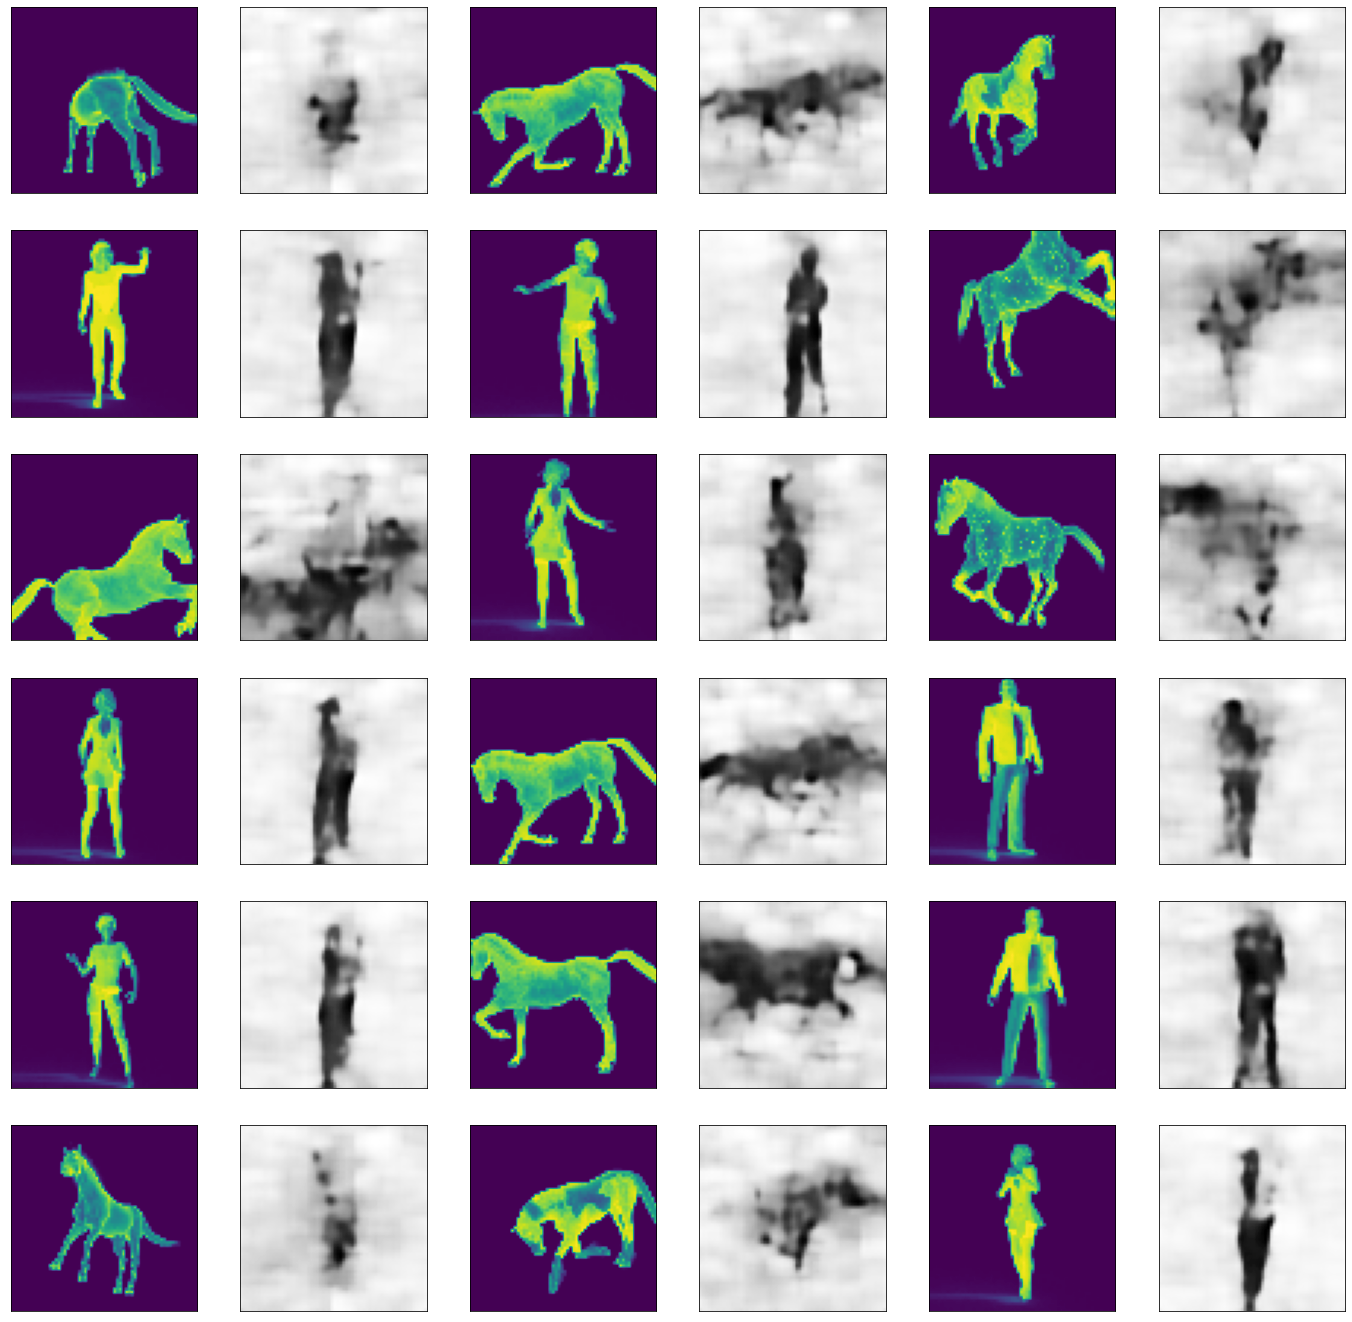

In [20]:
i = 1
plt.figure(figsize=(24, 24))
for i in range(1, 37, 2):
  plt.subplot(6, 6, i)
  plt.xticks([])
  plt.yticks([])
  n = (i-1)//2
  plt.imshow(img_test[n,:,:])
  plt.subplot(6, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(predict[n,:,:].reshape(64, 64), cmap='binary')
plt.show()

# Предсказание енкодера и кластеризация

In [27]:
encoder_predict_test = encoder.predict(img_test_conv)
calasters_model = [KMeans, SpectralClustering, FeatureAgglomeration, MeanShift, MiniBatchKMeans]
cluster_model = calasters_model[0](2)

In [28]:
cluster_model.fit(encoder_predict_test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
cluster_predict = cluster_model.predict(encoder_predict_test)
print(cluster_predict)

[1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0
 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0
 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0]


In [30]:
print(label_test[cluster_predict == 1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [31]:
cluster_true = label_test[cluster_predict == 1]
print(cluster_true[cluster_true == 1].shape)
print(cluster_true[cluster_true == 0].shape)

(0,)
(101,)


In [32]:
cluster_false = label_test[cluster_predict == 0]
print(cluster_false[cluster_false == 1].shape)
print(cluster_false[cluster_false == 0].shape)

(128,)
(27,)


# Визуализируем классы

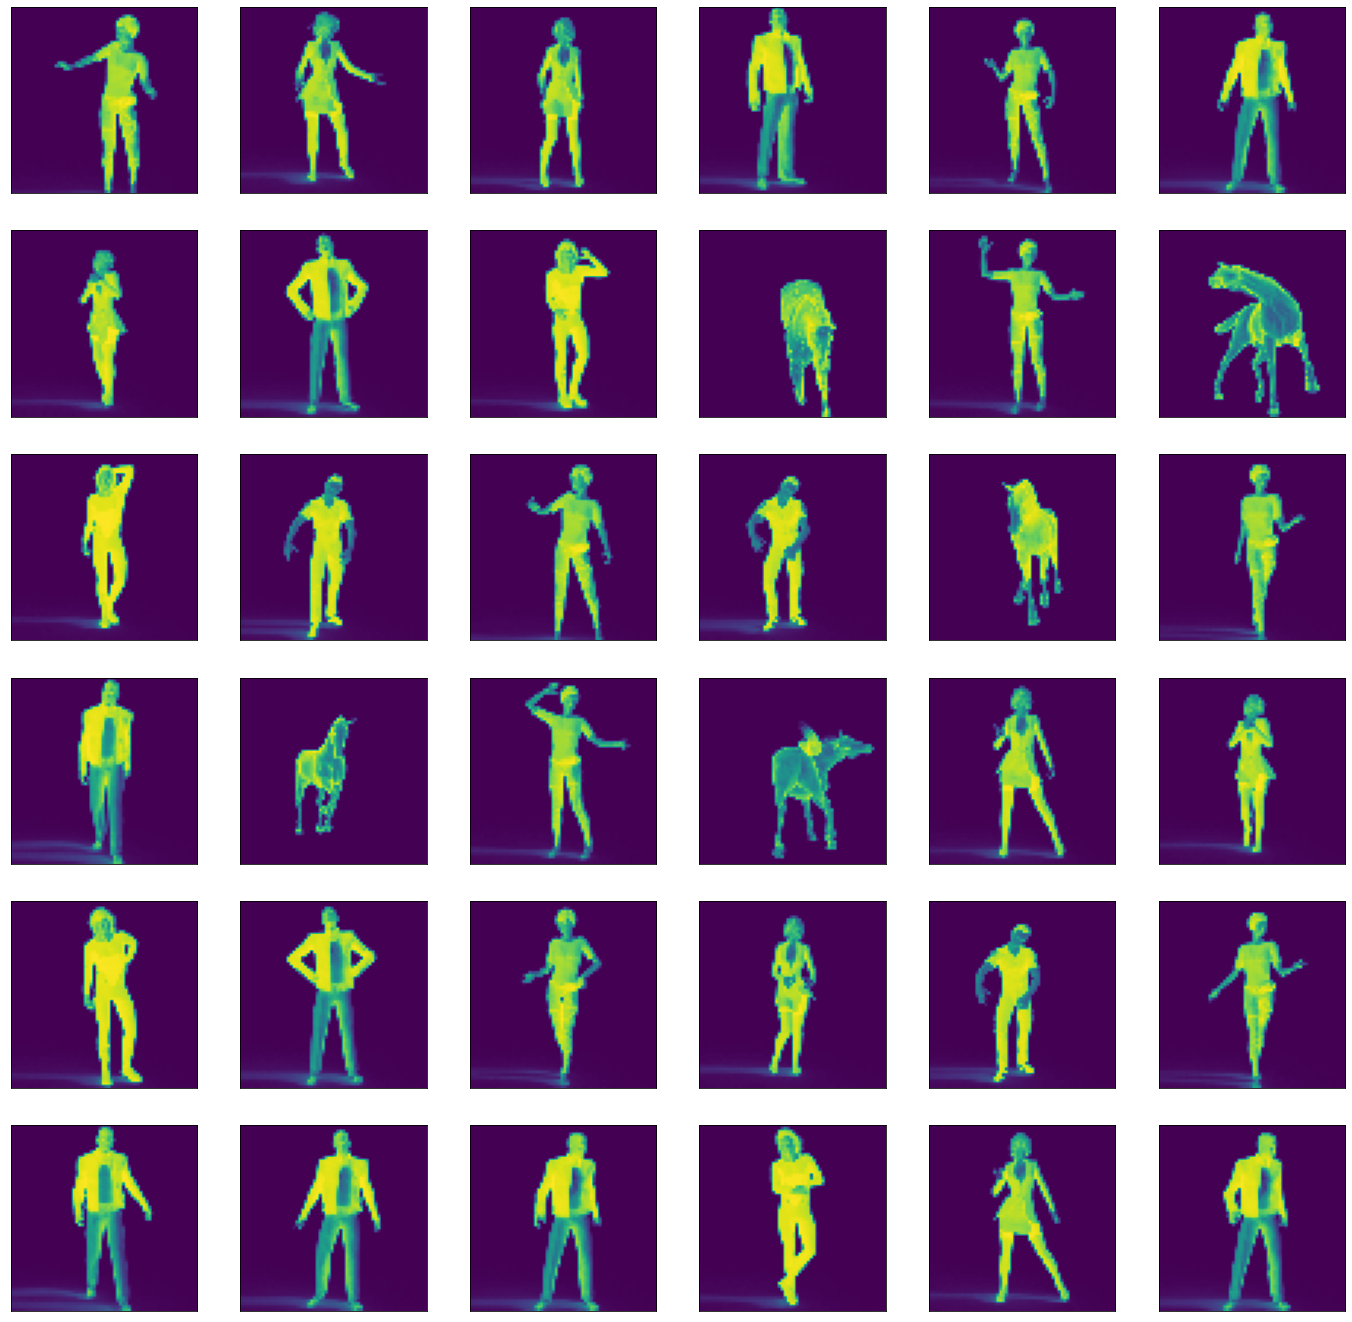

In [34]:
plt.figure(figsize=(24, 24))
for i in range(1, 37):
  plt.subplot(6, 6, i)
  plt.xticks([])
  plt.yticks([])
  n = (i-1)//2
  plt.imshow(img_test[cluster_predict == 0][i])
plt.show()

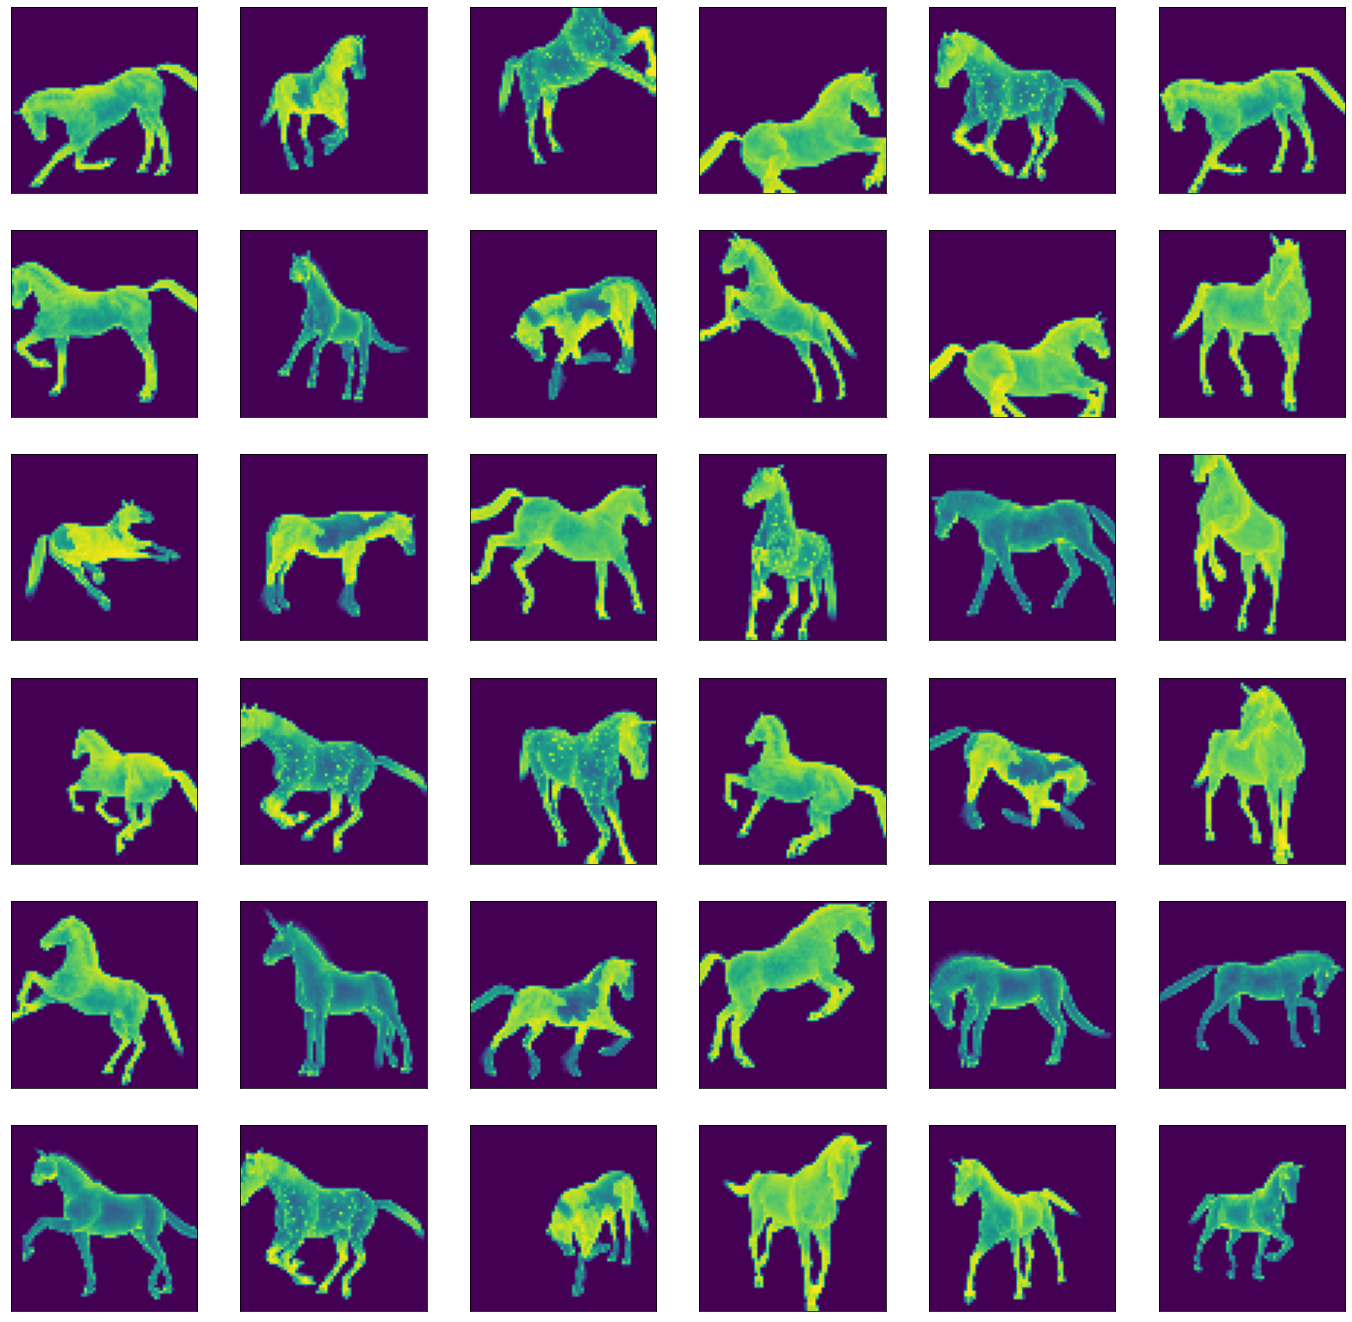

In [35]:
plt.figure(figsize=(24, 24))
for i in range(1, 37):
  plt.subplot(6, 6, i)
  plt.xticks([])
  plt.yticks([])
  n = (i-1)//2
  plt.imshow(img_test[cluster_predict == 1][i])
plt.show()

## Кажется, кластеризация более менее удалась. Класс 0 в кластеризации — люди, а 1 — лошади.

p.s. Пришлось помучиться. Почему то на этой базе автокодировщик никак не хочет работать. Я пробовал цветные, черно-белые, разного размера, EdgeDetection. Даже пробовал более сложную модель, в том числе разветвить. Но он так и не смог востанавливать их нормально.